In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [214]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
path = '/content/drive/MyDrive/CECS 550/lfw'

In [216]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

torch.Size([250, 250, 3])


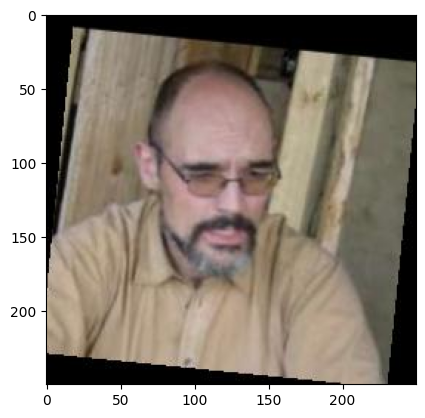

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# Application

**Autoencoder**



1.   Data Compression
2.   Data Denoising
3. Image Reconstruction and Restoration



**Variational Encoder**

1. Interpolation in Latent Space
2. Generative Modelling
3. Image Synthesis and Editing

# Architecture

**Autoencoder**

It has an encoder and a decoder where encoder compresses data into latent space reprentation and decoder reconstructs the data.

The process of encoding to a latent space is deterministic, meaning for a given input, the encoder produces a specific point in the latent space.

**Variational Autoencoder**

This too has encoder and decoder but VAE maps the input data to a probability distribution in latent space. To allow for gradient descent training, VAEs use a reparameterization where the sampling operation is reformulated to be differentiable.

# Loss Function

**Autoencoder**

The loss function in an AE is typically a reconstruction loss that measures the difference between the input and its reconstruction which usually are Mean Squared Error (MSE) or Binary Cross-Entropy.

**Variational Autoencoder**

VAE loss function has two terms. The first term is the reconstruction loss, similar to AE. The second term is the Kullback-Leibler (KL) divergence between the learned latent distribution and a prior distribution.

The KL divergence acts as a regularization component. It encourages the distribution of the latent variables to be close to the prior distribution. This ensures continuous latent space and prevents overfitting.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [241]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)

        self.flattened_size = 128 * (250 // 2 // 2 // 2) * (250 // 2 // 2 // 2)

        self.fc_mu = nn.Linear(self.flattened_size, 512)
        self.fc_logvar = nn.Linear(self.flattened_size, 512)

        self.dec_fc = nn.Linear(512, self.flattened_size)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.adjust_size = nn.AdaptiveAvgPool2d((250, 250))

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = torch.flatten(x, start_dim=1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.dec_fc(z))
        z = z.view(-1, 128, 31, 31)

        z = F.relu(self.dec_conv1(z))
        z = F.relu(self.dec_conv2(z))
        z = torch.relu(self.dec_conv3(z))

        z = self.adjust_size(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
def kl_divergence(logvar, mu):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [242]:
model = VAE().to(device)

In [243]:
images, _ = next(iter(dataloader))
images = images.to(device)
reconstructed, mu, logvar = model(images)

In [244]:
encoder_output_shape = mu.shape
reconstructed_images_shape = reconstructed.shape

In [245]:
print(encoder_output_shape)
print(reconstructed_images_shape)

torch.Size([32, 512])
torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [246]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in VAE: {total_params}")

Total number of parameters in VAE: 189395395


1. Reconstruction Loss, here the choice for reconstruction loss is Mean Squared Error which measures the squared differences between the original and reconstructed image. This loss is preferred as the pixels in the images has a range of values.

$\text{MSE Loss} = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$

2. KL divergence adds regularization term to a loss function measuring how much distribution of latent variable deviate from a prior distribution. By penalizing deviations from the prior distribution, the KL divergence encourages the latent space to be well-organized and makes the latent space more interpretable and ensures that sampling from the latent space is meaningful.

$\text{KL Divergence} = -0.5 \times \sum \left( 1 + \log(\sigma^2) - \mu^2 - \sigma^2 \right) $

* create an optimizer for training

In [247]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [251]:
#loss_function = nn.MSELoss(reduction='sum')

# def vae_loss(reconstructed_x, x, mu, logvar):
#     recon_loss = loss_function(reconstructed_x, x)

#     divergence = kl_divergence(logvar, mu)

#     loss = recon_loss + divergence
#     return loss

def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    divergence = kl_divergence(logvar, mu)
    return recon_loss + divergence

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

1. At the beginning when the loss was not decreasing, I added a $\beta$ value to KL divergence to fine-tune the model.

$ \text{loss} = \text{recon\_loss} + \beta \times \text{kl\_divergence} $

This way I had better control on the impact of KL divergence on the overall loss. For all $\beta$ values above 1 will give greater loss, for all values below 1 would see a reduce in effect of KL divergence on the loss. And for all values equal to 1 will see the normal effect of divergence. This idea was then droppped to test the actual KL divergence results on the data.

2. The final idea was to increase the latent space. As the larger space give the model with more capacity to encode and thereby reducing the overall loss.  A smaller latent space can act as a bottleneck, forcing the model to compress and potentially lose important information about the input data. Increasing the latent space further could give better result for the data.

In [249]:
# for epoch in range(10):
#     images, _ = next(iter(dataloader))
#     images = images.to(device)
#     reconstructed, mu, logvar = model(images)

#     loss = vae_loss(reconstructed, images, mu, logvar)
#     optim.zero_grad()
#     loss.backward()

#     optim.step()

#     if torch.isnan(loss):
#       print(f'Epoch [{epoch+1}/10], Loss: nan - stopping training')
#       break
#     else:
#       print(f'Epoch [{epoch+1}/10], Loss: {loss.item()}')

for epoch in range(15):
    total_loss = 0
    # images, _ = next(iter(dataloader))
    # images = images.to(device)
    # reconstructed, mu, logvar = model(images)
    # loss = vae_loss(reconstructed, images, mu, logvar, beta)
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    # total_loss += loss.item()
    # avg_loss = total_loss / len(dataloader.dataset)
    # scheduler.step()  # Adjust the learning rate
    # print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')

    for images, _ in dataloader:
        images = images.to(device)
        reconstructed, mu, logvar = model(images)

        loss = vae_loss(reconstructed, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{15}], Average Loss: {avg_loss:.4f}')

Epoch [1/15], Average Loss: 8647.6469
Epoch [2/15], Average Loss: 4718.3387
Epoch [3/15], Average Loss: 3700.5528
Epoch [4/15], Average Loss: 3194.7007
Epoch [5/15], Average Loss: 2894.2655
Epoch [6/15], Average Loss: 2662.4136
Epoch [7/15], Average Loss: 2619.2372
Epoch [8/15], Average Loss: 2589.0278
Epoch [9/15], Average Loss: 2561.6662
Epoch [10/15], Average Loss: 2535.5359
Epoch [11/15], Average Loss: 2509.8476
Epoch [12/15], Average Loss: 2506.2289
Epoch [13/15], Average Loss: 2502.4622
Epoch [14/15], Average Loss: 2499.1666
Epoch [15/15], Average Loss: 2496.6244


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

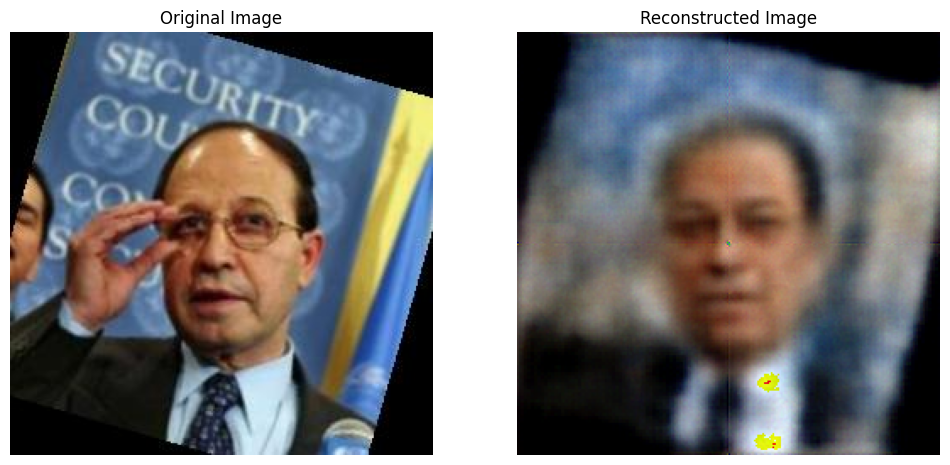

In [256]:
data = iter(dataloader)
images, _ = next(data)

random_index = torch.randint(len(images), size=(1,)).item()
original_img = images[random_index]
input_img = original_img.unsqueeze(0)
input_img = input_img.to(device)
model.eval()
with torch.no_grad():
    reconstructed_img, _, _ = model(input_img)

original_img = original_img.cpu()
reconstructed_img = reconstructed_img.squeeze(0).cpu()

transform_to_pil = transforms.ToPILImage()
original_img_pil = transform_to_pil(original_img)
reconstructed_img_pil = transform_to_pil(reconstructed_img)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img_pil)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_pil)
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()